In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
#pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import splitfolders

In [ ]:
input_folder = "/home/vm-ubuntu/datasets/fruits/train"
output_folder = "/home/vm-ubuntu/datasets/fruits/splitted"

In [ ]:
# train/test split of the initial train folder
#splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .2, .1))

In [ ]:
train_dir = r'/home/vm-ubuntu/datasets/fruits/splitted/train'
val_dir = r'/home/vm-ubuntu/datasets/fruits/splitted/val'

In [ ]:
num_classes = 33
batch_size = 8
num_epochs = 5
feature_extract = True
input_size = 224

In [ ]:
transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    

train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(val_dir, transform=transform)

In [ ]:
print("Len train:", train_dataset.classes)
print("Len val:", len(val_dataset))

Len train: ['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']
Len val: 3361


In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
test_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [ ]:
print(len(train_data_loader.dataset))
print(len(test_data_loader.dataset))

11787
3361


In [ ]:
dataloaders_dict = {"train":train_data_loader, "val":test_data_loader}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [ ]:
model = models.vgg16(pretrained=True)

/home/vm-ubuntu/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/vm-ubuntu/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
model.classifier = model.classifier[:-4]

In [ ]:
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
)


In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
set_parameter_requires_grad(model, feature_extract)

In [ ]:
#change last layer
num_ftrs = model.classifier[0].out_features
model.classifier[2] = nn.Linear(num_ftrs,num_classes)

In [ ]:
# function for training and validation
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
model = model.to(device)

In [ ]:
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=4096, out_features=33, bias=True)
)


In [ ]:
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 classifier.2.weight
	 classifier.2.bias


In [ ]:
optimizer = optim.SGD(params_to_update, lr=0.1, momentum=0.9)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
# sample batch shape
dataiter = iter(train_data_loader)
images, labels = dataiter.next()
print(type(images))
print(images[0].shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([3, 224, 224])
torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


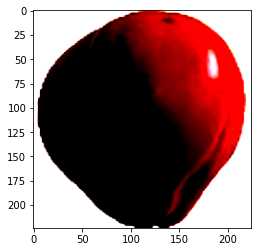

In [ ]:
plt.imshow(images[0].permute(1, 2, 0))

In [ ]:
# train and validate the model after each epoch, save the best model in model_ft
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/5
----------
train Loss: 8.0286 Acc: 0.9589
val Loss: 0.0614 Acc: 0.9985

Epoch 2/5
----------
train Loss: 0.0393 Acc: 0.9991
val Loss: 0.0000 Acc: 0.9997

Epoch 3/5
----------
train Loss: 0.0000 Acc: 0.9997
val Loss: 0.0000 Acc: 0.9997

Epoch 4/5
----------
train Loss: 0.0000 Acc: 0.9997
val Loss: 0.0000 Acc: 0.9997

Epoch 5/5
----------
train Loss: 0.0000 Acc: 0.9997
val Loss: 0.0000 Acc: 0.9997

Training complete in 18m 35s
Best val Acc: 0.999702


In [ ]:
text_file = open("trained_vgg16.ml", "wb")

In [ ]:
saved_model = torch.save(model_ft, text_file)

In [ ]:
text_file.close()